In [1]:
#!/usr/bin/env python
"""Variational auto-encoder for MNIST data.
References
----------
http://edwardlib.org/tutorials/decoder
http://edwardlib.org/tutorials/inference-networks
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import numpy as np
import os
import tensorflow as tf

from edward.models import Bernoulli, Normal
from edward.util import Progbar
from keras.layers import Dense
from observations import mnist
from scipy.misc import imsave

Using TensorFlow backend.


In [2]:
def generator(array, batch_size):
  """Generate batch with respect to array's first axis."""
  start = 0  # pointer to where we are in iteration
  while True:
    stop = start + batch_size
    diff = stop - array.shape[0]
    if diff <= 0:
      batch = array[start:stop]
      start += batch_size
    else:
      batch = np.concatenate((array[start:], array[:diff]))
      start = diff
    batch = batch.astype(np.float32) / 255.0  # normalize pixel intensities
    batch = np.random.binomial(1, batch)  # binarize images
    yield batch


ed.set_seed(42)

In [3]:
data_dir = "../data"
out_dir = "./out"
if not os.path.exists(out_dir):
  os.makedirs(out_dir)

In [4]:
M = 100  # batch size during training
d = 2  # latent dimension

# DATA. MNIST batches are fed at training time.
(x_train, _), (x_test, _) = mnist(data_dir)
x_train_generator = generator(x_train, M)

In [5]:
# MODEL
# Define a subgraph of the full model, corresponding to a minibatch of
# size M.
z = Normal(loc=tf.zeros([M, d]), scale=tf.ones([M, d]))
hidden = Dense(256, activation='relu')(z.value())
x = Bernoulli(logits=Dense(28 * 28)(hidden))

In [6]:
# INFERENCE
# Define a subgraph of the variational model, corresponding to a
# minibatch of size M.
x_ph = tf.placeholder(tf.int32, [M, 28 * 28])
hidden = Dense(256, activation='relu')(tf.cast(x_ph, tf.float32))
qz = Normal(loc=Dense(d)(hidden),
            scale=Dense(d, activation='softplus')(hidden))

In [7]:
# Bind p(x, z) and q(z | x) to the same TensorFlow placeholder for x.
inference = ed.KLqp({z: qz}, data={x: x_ph})
optimizer = tf.train.RMSPropOptimizer(0.01, epsilon=1.0)
inference.initialize(optimizer=optimizer)

In [8]:
tf.global_variables_initializer().run()

n_epoch = 100
n_iter_per_epoch = x_train.shape[0] // M
for epoch in range(1, n_epoch + 1):
    print("Epoch: {0}".format(epoch))
    avg_loss = 0.0

    pbar = Progbar(n_iter_per_epoch)
    for t in range(1, n_iter_per_epoch + 1):
        pbar.update(t)
        x_batch = next(x_train_generator)
        info_dict = inference.update(feed_dict={x_ph: x_batch})
        avg_loss += info_dict['loss']

  # Print a lower bound to the average marginal likelihood for an
  # image.
    avg_loss = avg_loss / n_iter_per_epoch
    avg_loss = avg_loss / M
    print("-log p(x) <= {:0.3f}".format(avg_loss))

    # Prior predictive check.
    images = x.eval()
    for m in range(M):
        imsave(os.path.join(out_dir, '%d.png') % m, images[m].reshape(28, 28))

Epoch: 1
600/600 [100%] ██████████████████████████████ Elapsed: 5s
-log p(x) <= 181.148
Epoch: 2
 19/600 [  3%]                                ETA: 5s

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:25: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


600/600 [100%] ██████████████████████████████ Elapsed: 5s
-log p(x) <= 167.170
Epoch: 3
600/600 [100%] ██████████████████████████████ Elapsed: 5s
-log p(x) <= 164.639
Epoch: 4
600/600 [100%] ██████████████████████████████ Elapsed: 5s
-log p(x) <= 163.180
Epoch: 5
600/600 [100%] ██████████████████████████████ Elapsed: 5s
-log p(x) <= 162.354
Epoch: 6
600/600 [100%] ██████████████████████████████ Elapsed: 5s
-log p(x) <= 161.637
Epoch: 7
600/600 [100%] ██████████████████████████████ Elapsed: 5s
-log p(x) <= 160.963
Epoch: 8
600/600 [100%] ██████████████████████████████ Elapsed: 5s
-log p(x) <= 160.564
Epoch: 9
600/600 [100%] ██████████████████████████████ Elapsed: 5s
-log p(x) <= 160.198
Epoch: 10
600/600 [100%] ██████████████████████████████ Elapsed: 5s
-log p(x) <= 159.860
Epoch: 11
600/600 [100%] ██████████████████████████████ Elapsed: 5s
-log p(x) <= 159.619
Epoch: 12
600/600 [100%] ██████████████████████████████ Elapsed: 5s
-log p(x) <= 159.390
Epoch: 13
600/600 [100%] █████████████

600/600 [100%] ██████████████████████████████ Elapsed: 5s
-log p(x) <= 156.463
Epoch: 95
600/600 [100%] ██████████████████████████████ Elapsed: 5s
-log p(x) <= 156.457
Epoch: 96
600/600 [100%] ██████████████████████████████ Elapsed: 5s
-log p(x) <= 156.400
Epoch: 97
600/600 [100%] ██████████████████████████████ Elapsed: 5s
-log p(x) <= 156.435
Epoch: 98
600/600 [100%] ██████████████████████████████ Elapsed: 5s
-log p(x) <= 156.501
Epoch: 99
600/600 [100%] ██████████████████████████████ Elapsed: 5s
-log p(x) <= 156.356
Epoch: 100
600/600 [100%] ██████████████████████████████ Elapsed: 5s
-log p(x) <= 156.311


In [9]:
import matplotlib.pylab as plt

In [10]:
%matplotlib inline

In [24]:
ztmp= z.eval()

In [25]:
ztmp

array([[ 1.25764418,  0.55881143],
       [-0.47397289, -0.46549419],
       [-0.58471507, -1.46990907],
       [ 0.00755164,  0.16298994],
       [-0.03434385, -0.04578157],
       [-0.75007969, -0.32772046],
       [-0.87311888, -1.33670914],
       [ 0.1462032 ,  1.70584118],
       [-0.26507387,  0.24584369],
       [-1.45648181, -1.09543467],
       [-0.30748132,  2.39312768],
       [-2.37648988, -0.07302701],
       [-0.52727735, -0.75984204],
       [-1.49419689, -0.41530433],
       [ 1.98378146,  1.11680591],
       [ 0.53445488,  0.6692555 ],
       [-0.1641655 ,  0.71742064],
       [ 0.48056072,  0.89510924],
       [ 1.4921124 , -2.20925307],
       [ 1.9442544 , -0.48600927],
       [-0.87354106, -0.75340205],
       [-0.34001321, -0.66593635],
       [-1.11166251,  0.19331115],
       [-0.41793761, -2.99240923],
       [ 1.36540246, -0.32365903],
       [-0.67081714,  0.83552039],
       [-0.63153076,  0.30917069],
       [-1.1177237 , -1.80079269],
       [ 0.49905485,

(array([  1.,   1.,   2.,   4.,  11.,  15.,  18.,  24.,  10.,   7.,   3.,
          0.,   4.]),
 array([-2.99240923, -2.5615594 , -2.13070957, -1.69985975, -1.26900992,
        -0.83816009, -0.40731027,  0.02353956,  0.45438939,  0.88523922,
         1.31608904,  1.74693887,  2.1777887 ,  2.60863853]),
 <a list of 13 Patch objects>)

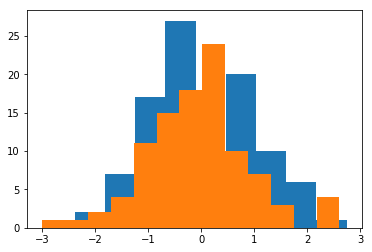

In [26]:
plt.hist(ztmp[:,0],'auto')
plt.hist(ztmp[:,1],'auto')

In [31]:
x.get_ancestors()[0] is z

True

In [60]:
?ed.copy

In [61]:
x.get_variables()

[<tf.Variable 'dense_2/bias:0' shape=(784,) dtype=float32_ref>,
 <tf.Variable 'dense_1/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'dense_1/kernel:0' shape=(2, 256) dtype=float32_ref>,
 <tf.Variable 'dense_2/kernel:0' shape=(256, 784) dtype=float32_ref>]

In [55]:
xtmp = ed.copy(x, {z:ztmp})

In [56]:
init_new_vars_op = tf.variables_initializer(xtmp.get_variables())

In [59]:
sess = tf.Session()
#sess.run(init_new_vars_op)
tmp = sess.run(xtmp.value())

FailedPreconditionError: Attempting to use uninitialized value dense_1/bias
	 [[Node: dense_1/bias/read = Identity[T=DT_FLOAT, _class=["loc:@dense_1/bias"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](dense_1/bias)]]

Caused by op u'dense_1/bias/read', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-9b9fd99eddd7>", line 5, in <module>
    hidden = Dense(256, activation='relu')(z.value())
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py", line 576, in __call__
    self.build(input_shapes[0])
  File "/usr/local/lib/python2.7/dist-packages/keras/layers/core.py", line 836, in build
    constraint=self.bias_constraint)
  File "/usr/local/lib/python2.7/dist-packages/keras/legacy/interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py", line 400, in add_weight
    constraint=constraint)
  File "/usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py", line 380, in variable
    v = tf.Variable(value, dtype=tf.as_dtype(dtype), name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/variables.py", line 213, in __init__
    constraint=constraint)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/variables.py", line 356, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/array_ops.py", line 125, in identity
    return gen_array_ops.identity(input, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 2071, in identity
    "Identity", input=input, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value dense_1/bias
	 [[Node: dense_1/bias/read = Identity[T=DT_FLOAT, _class=["loc:@dense_1/bias"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](dense_1/bias)]]


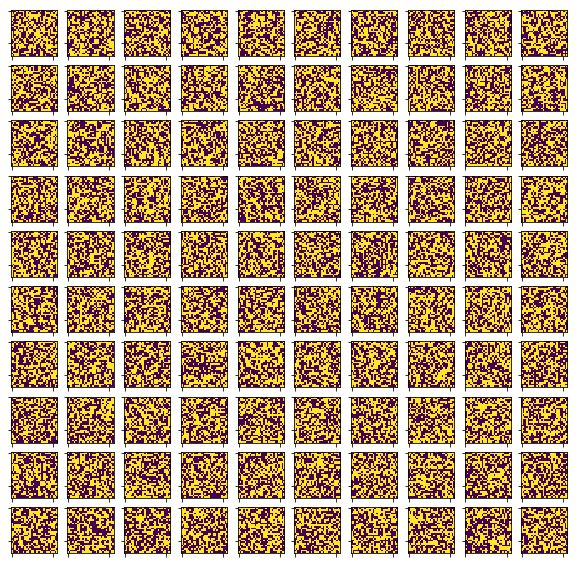

In [58]:
plt.figure(figsize=(10,10))
for i in range(1,101):
    ax = plt.subplot(10,10,i)
    plt.imshow(tmp[i-1].reshape(28,28))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

(array([  5.,   4.,   9.,  16.,  23.,  21.,  15.,   7.]),
 array([-2.47848031, -1.93655479, -1.39462927, -0.85270376, -0.31077824,
         0.23114728,  0.7730728 ,  1.31499831,  1.85692383]),
 <a list of 8 Patch objects>)

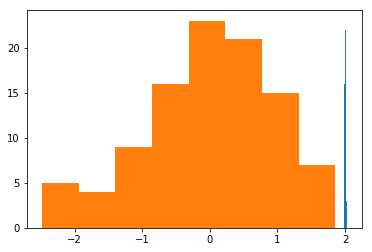

In [16]:
ztmp1 = np.random.normal(0,1,(100,2))
ztmp1[:,0] *= 0.01
ztmp1[:,0] += 2

plt.hist(ztmp1[:,0],'auto')
plt.hist(ztmp1[:,1],'auto')

In [17]:
xtmp1 = ed.copy(x, {z:ztmp1})

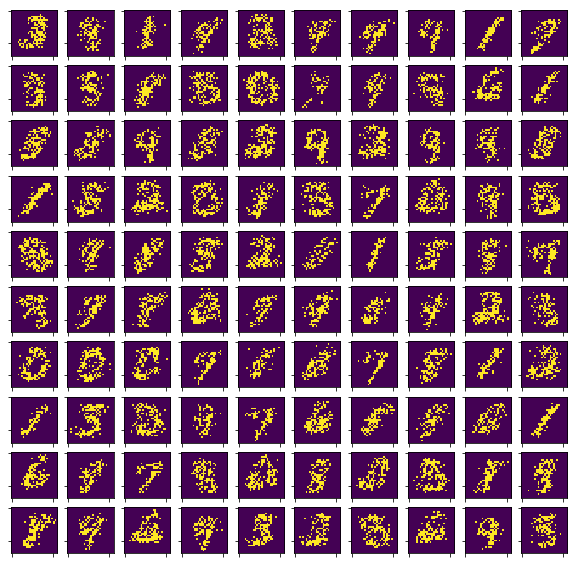

In [18]:
plt.figure(figsize=(10,10))
for i in range(1,101):
    ax = plt.subplot(10,10,i)
    plt.imshow(xtmp1.eval()[i-1].reshape(28,28))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

(array([  1.,   1.,   8.,   9.,  12.,  23.,  22.,  14.,   6.,   4.]),
 array([ 1.97240827,  1.97720529,  1.9820023 ,  1.98679932,  1.99159634,
         1.99639335,  2.00119037,  2.00598739,  2.01078441,  2.01558142,
         2.02037844]),
 <a list of 10 Patch objects>)

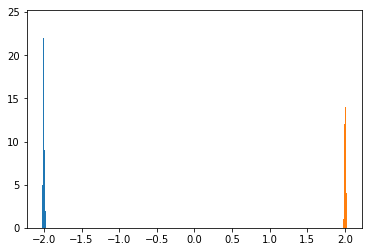

In [19]:
ztmp2 = np.random.normal(0,1,(100,2))
ztmp2[:,1] *= 0.01
ztmp2[:,1] += 2
ztmp2[:,0] *= 0.01
ztmp2[:,0] -= 2

plt.hist(ztmp2[:,0],'auto')
plt.hist(ztmp2[:,1],'auto')

In [20]:
xtmp3 = ed.copy(x, {z:ztmp2})

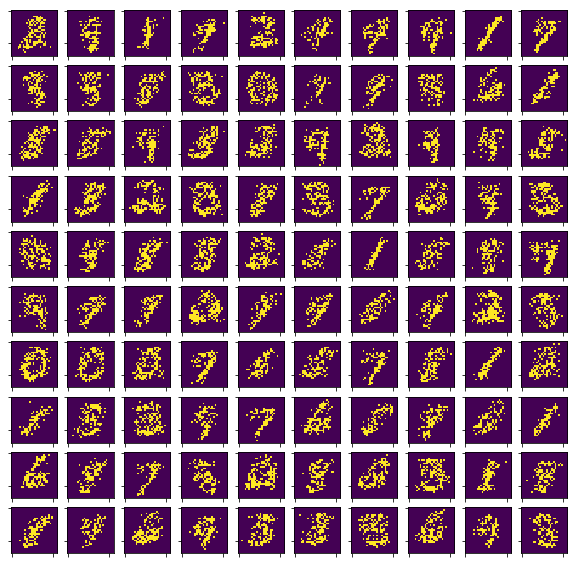

In [21]:
plt.figure(figsize=(10,10))
for i in range(1,101):
    ax = plt.subplot(10,10,i)
    plt.imshow(xtmp3.eval()[i-1].reshape(28,28))
    ax.set_xticklabels([])
    ax.set_yticklabels([])